# Lab 6 by Nicholas Fong, worked with Mikael Figueroa

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors, metrics, grid_search, cross_validation, preprocessing

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(os.path.join('boston.csv'))

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,...,TAX,PTRATIO,BLACK,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,...,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,...,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,...,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,...,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,...,222,18.7,396.90,5.33,36.2


The Boston dataset concerns itself with housing values in suburbs of Boston.  A description of the dataset is as follows:

- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sqft
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centers
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate (per ten thousands of dollars)
- PTRATIO: pupil-teacher ratio by town
- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT: % lower status of the population
- MEDV: Median value of owner-occupied homes (in thousands of dollars)

## Question 1: Let's first categorize `MEDV` to 4 groups: Bottom 20% as Level 1, next 30% as Level 2, next 30% categorized as Level 3, and the top 20% as Level 4.  Please create a new variable `MEDV_Category` that stores the level number

In [4]:
def getLevel(x):
    if x <= df.MEDV.quantile(0.2):
        return 1
    elif x <= df.MEDV.quantile(0.5):
        return 2
    elif x <= df.MEDV.quantile(0.8):
        return 3
    elif x <= df.MEDV.quantile(1):
        return 4
    else:
        return -1 #error
MEDV_Category = lambda x: getLevel(x)
df['MEDV_Category'] = df.MEDV.map(MEDV_Category)
df['MEDV_Category'] #I checked, this works as it should

0      3
1      3
2      4
3      4
4      4
      ..
501    3
502    2
503    3
504    3
505    1
Name: MEDV_Category, dtype: int64

## Our goal is to predict `MEDV_Category` based on `RM`, `PTRATIO`, and `LSTAT`

## Question 2: First normalize `RM`, `PTRATIO`, and `LSTAT` into the new variables `RM_s`, `PTRATIO_s`, and `LSTAT_s`.  By normalizing, we mean to scale each variable between 0 and 1 with the lowest value as 0 and the highest value as 1

In [5]:
df['RM_s'] = (df.RM - df.RM.min()) / (df.RM.max() - df.RM.min())
df['PTRATIO_s'] = (df.PTRATIO - df.PTRATIO.min()) / (df.PTRATIO.max() - df.PTRATIO.min())  #Rescale the variables
df['LSTAT_s'] = (df.LSTAT - df.LSTAT.min()) / (df.LSTAT.max() - df.LSTAT.min())
df

,CRIM,ZN,INDUS,CHAS,NOX,...,MEDV,MEDV_Category,RM_s,PTRATIO_s,LSTAT_s
0,0.00632,18.0,2.31,0,0.538,...,24.0,3,0.577505,0.287234,0.089680
1,0.02731,0.0,7.07,0,0.469,...,21.6,3,0.547998,0.553191,0.204470
2,0.02729,0.0,7.07,0,0.469,...,34.7,4,0.694386,0.553191,0.063466
3,0.03237,0.0,2.18,0,0.458,...,33.4,4,0.658555,0.648936,0.033389
4,0.06905,0.0,2.18,0,0.458,...,36.2,4,0.687105,0.648936,0.099338
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,...,22.4,3,0.580954,0.893617,0.219095
502,0.04527,0.0,11.93,0,0.573,...,20.6,2,0.490324,0.893617,0.202815
503,0.06076,0.0,11.93,0,0.573,...,23.9,3,0.654340,0.893617,0.107892
504,0.10959,0.0,11.93,0,0.573,...,22.0,3,0.619467,0.893617,0.131071


## Question 2: Run a KNN classifier with 5 nearest neighbors and report your misclassification error; set weights to uniform

In [6]:
x = df[ ['RM_s', 'PTRATIO_s', 'LSTAT_s'] ]
y = df['MEDV_Category']
neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform').fit(x, y).score(x, y)

0.7865612648221344

Answer: Classification accuracy is 78.66%, so misclassification error is 21.34%

## Question 3: Is this error reliable?

Answer: Since we use the entire data set to run our nearest neighbor test, the error is consistent. Any new data that is similar to old data can expect a similar classification accuracy

## Question 4: Now use 10-fold cross-validation to choose the most efficient `k`

In [7]:
train_df = df.sample(frac = .8).sort_index()
train_df

,CRIM,ZN,INDUS,CHAS,NOX,...,MEDV,MEDV_Category,RM_s,PTRATIO_s,LSTAT_s
0,0.00632,18.0,2.31,0,0.538,...,24.0,3,0.577505,0.287234,0.089680
1,0.02731,0.0,7.07,0,0.469,...,21.6,3,0.547998,0.553191,0.204470
2,0.02729,0.0,7.07,0,0.469,...,34.7,4,0.694386,0.553191,0.063466
5,0.02985,0.0,2.18,0,0.458,...,28.7,4,0.549722,0.648936,0.096026
6,0.08829,12.5,7.87,0,0.524,...,22.9,3,0.469630,0.276596,0.295254
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,...,22.4,3,0.580954,0.893617,0.219095
502,0.04527,0.0,11.93,0,0.573,...,20.6,2,0.490324,0.893617,0.202815
503,0.06076,0.0,11.93,0,0.573,...,23.9,3,0.654340,0.893617,0.107892
504,0.10959,0.0,11.93,0,0.573,...,22.0,3,0.619467,0.893617,0.131071


In [8]:
test_df = df.drop(train_df.index)
test_df

,CRIM,ZN,INDUS,CHAS,NOX,...,MEDV,MEDV_Category,RM_s,PTRATIO_s,LSTAT_s
3,0.03237,0.0,2.18,0,0.458,...,33.4,4,0.658555,0.648936,0.033389
4,0.06905,0.0,2.18,0,0.458,...,36.2,4,0.687105,0.648936,0.099338
9,0.17004,12.5,7.87,0,0.524,...,18.9,2,0.468097,0.276596,0.424117
10,0.22489,12.5,7.87,0,0.524,...,15.0,1,0.539567,0.276596,0.516556
15,0.62739,0.0,8.14,0,0.538,...,19.9,2,0.435524,0.893617,0.185982
...,...,...,...,...,...,...,...,...,...,...,...
487,4.83567,0.0,18.10,0,0.583,...,20.6,2,0.449128,0.808511,0.268212
491,0.10574,0.0,27.74,0,0.609,...,13.6,1,0.464074,0.797872,0.450883
494,0.27957,0.0,9.69,0,0.585,...,24.5,3,0.453152,0.702128,0.327263
495,0.17899,0.0,9.69,0,0.585,...,23.1,3,0.404100,0.702128,0.437914


In [9]:
train_x = train_df[ ['RM_s', 'PTRATIO_s', 'LSTAT_s'] ]
train_y = train_df['MEDV_Category']
k_cv = 10 # 10-fold CV
k_nn = range(1, len(train_df) * (k_cv - 1) / k_cv) # k-NN

gs = grid_search.GridSearchCV(
    estimator = neighbors.KNeighborsClassifier(),
    param_grid = {'n_neighbors': k_nn},
    cv = cross_validation.KFold(len(train_df), n_folds = k_cv)
)

gs.fit(train_x, train_y)

score_df = pd.DataFrame({'k': [score.parameters['n_neighbors'] for score in gs.grid_scores_],
    'Score': [score.mean_validation_score for score in gs.grid_scores_]})

score_df

,Score,k
0,0.577778,1
1,0.627160,2
2,0.617284,3
3,0.644444,4
4,0.644444,5
...,...,...
358,0.170370,359
359,0.170370,360
360,0.170370,361
361,0.170370,362


In [10]:
score_df[score_df.Score == score_df.Score.max()]

,Score,k
24,0.696296,25


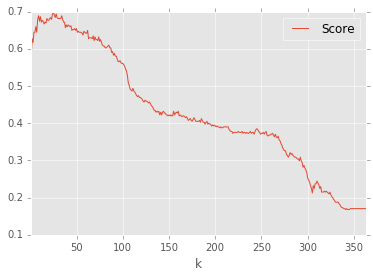

In [11]:
score_df.set_index('k').plot()  #See the pattern for differing k values

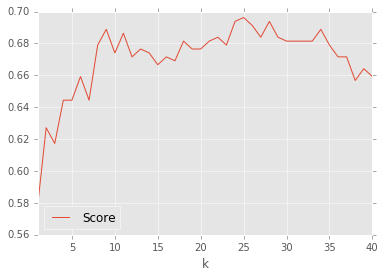

In [12]:
score_df.set_index('k')[:40].plot()  #Zoom in on the bottom 40 k values since those have the highest score

## Question 5: Explain your findings

Answer: Over several repeated trials with differing values taken for our training set, overall the best k value seems to be around 21. Sometimes a lower k value of around 9 achieves optimal scores, but usually a k value of around 21 is very close in ranking. This means that we can best guess what category a value is in by looking at the 21 nearest neighbors and choosing the most popular one. Classification accuracy is about 69.4%.

## Question 6: Train your model with the optimal `k` you found above (don't worry if it changes from time to time - if that is the case use the one that is usually the best)

In [13]:
model = neighbors.KNeighborsClassifier(n_neighbors = 21, weights = 'uniform')
model.fit(train_x,train_y)
test_x = test_df[ ['RM_s', 'PTRATIO_s', 'LSTAT_s'] ]
test_y = test_df['MEDV_Category']
print 'train = ', model.score(train_x, train_y)
print 'test  = ', model.score(test_x, test_y)

train =  0.723456790123
test  =  0.732673267327


Answer: Our model with the optimal k value of 21 has a classification accuracy of about 72%

## Question 7: After training your model with that `k`, use it to predict the class of a neighborhood with `RM = 2`, `PRATIO = 19` and `LSTAT = 3.5` 

In [18]:
unknown = {'RM' : 2, 'LSTAT' : 3.5, 'PTRATIO' : 19}
unknown = pd.DataFrame.from_dict(data = unknown, orient = 'index').transpose() #Create a dataframe of the test data
print 'raw test data\n', unknown #test data
unknown['RM'] = (unknown.RM - df.RM.min()) / (df.RM.max() - df.RM.min())
unknown['PTRATIO'] = (unknown.PTRATIO - df.PTRATIO.min()) / (df.PTRATIO.max() - df.PTRATIO.min())  #Rescale the test data to match
unknown['LSTAT'] = (unknown.LSTAT - df.LSTAT.min()) / (df.LSTAT.max() - df.LSTAT.min())            #the scaled training data
print 'scaled test data\n', unknown #verify it was scaled properly
print 'predicted class of neighborhood:',model.predict(unknown)

raw test data
    RM  PTRATIO  LSTAT
0  2.0     19.0    3.5
scaled test data
         RM   PTRATIO     LSTAT
0 -0.299099  0.680851  0.048841
predicted class of neighborhood: [2]


Answer: 4

In [17]:
(unknown.LSTAT - df.LSTAT.min()) / (df.LSTAT.max() - df.LSTAT.min())

0   -0.045263
Name: LSTAT, dtype: float64